In [509]:
import time
import os


import numpy as np
import pandas as pd

import datetime as dt


from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc,roc_auc_score
from sklearn import neighbors

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.gaussian_process import GaussianProcessClassifier

In [510]:

models = {
            'linear' : {
                    'mod' : LogisticRegression(solver = 'saga'),
                    'par' : {'penalty' : ('l1','l2','elasticnet','none'),
                                'C': [1,1.5,2],
                            'l1_ratio':[0.2,0.5,0.8]}
                    },                     
            'gradient' : {
                    'mod' : GradientBoostingClassifier(warm_start = True),
                    'par' : {'loss' : ('deviance', 'exponential'),
                             'max_depth' : [3, 4, 5, 6, 7]}
                        },
           'tree':{'mod': DecisionTreeClassifier(),
                     'par':{'splitter':('best','random'),
                            'max_depth': [None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}},
            'svm' : {
                    'mod' : svm.SVC(probability=True),
                    'par' : {'kernel' : ( 'linear', 'rbf')}
                    },
        'RandomForest' : {
                    'mod' : RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, criterion = 'gini'),
                    'par' : {'max_depth' :[None, 2,4,6],
                            'min_samples_leaf':[1,5,8]}
                        },
        'Knn' : {
                    'mod' : neighbors.KNeighborsClassifier(),
                    'par' : {'n_neighbors' :[5, 10, 15],
                            'leaf_size':[15,25,30]}
                        },
        'GCP' : {
                    'mod' : GaussianProcessClassifier(),
                    'par' : {'optimizer' :['fmin_l_bfgs_b'],
                            }
                        }  
    
        }


In [511]:
def grid(x_name,n_proc, os_X_tt, os_Y_tt, X_test, y_test,  models, score = 'roc_auc', cv = 7):
    
    # Gridsearch
    
    result = dict()
    bestmodels = models.copy()
    for name in models:
        print('*'*80)
        print("Model: " + name)
        t_beg = time.time()

        pipeline = Pipeline([('scaler', StandardScaler()), (name,  bestmodels[name]['mod'])])          
        parameters = {}          
        for par in bestmodels[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = bestmodels[name]['par'][par]    
        aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc,\
                          scoring = score, verbose=2, cv = cv)
        aux.fit(os_X_tt, os_Y_tt)
        y_true, y_pred = y_test , aux.predict(X_test)
        
        #precision = precision_score(y_test, y_pred, average="macro")
        #recall = recall_score(y_test, y_pred, average="macro")  
        auc = roc_auc_score(y_test, y_pred, average="maco")
        #f1score = f1_score(y_test, y_pred, average="macro")
        accuracy = accuracy_score(y_test, y_pred)
        
        bestmodels[name]['bestModel'] = aux.best_estimator_
        bestmodels[name][score] = aux.best_score_
        bestmodels[name]['cols_order'] = os_X_tt.columns.values
        selection_time = time.time() - t_beg

        bestmodels[name]['selection_time'] = selection_time

        sample_f_path = f'modelos/{x_name}' + f'{name}_{dt.datetime.now().strftime("%Y%m%d-%H%M")}.sav'

        print(f"Saving model at {sample_f_path}")    
        joblib.dump(bestmodels[name]['bestModel'], sample_f_path)

        print(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        print(f"El error {score} de la familia {name} es: {bestmodels[name][score]:0.3f}")
        print('*'*80)
    
        #result[name] = {"auc": round(auc,3), "precision": round(precision,3), "recall": round(recall,3),"f1score": round(f1score,3)}
        result[name] = {"auc": round(auc,3), "accuracy": round(accuracy,3)}
        
    mod_name = None
    best_mae = -np.inf
    for name in models:
        if bestmodels[name][score] > best_mae:
            mod_name = name
            best_mae = bestmodels[name][score]

    print(f"best model: " + mod_name + f" with an error {score} of: " + str(best_mae))
    
    return bestmodels, result

In [512]:
#Bestmodels

def get_max(dictionary, key_val):
    auc_list = []
    auc_dict = {}

    for key in dictionary:
        for key2 in dictionary[key]:
            if key_val in key2:
                auc_list.append(dictionary[key][key_val])

    max_key = ''
    max_val = max(auc_list)

    for key in dictionary:
        for key2 in dictionary[key]:
            if max_val == dictionary[key][key_val]:
                max_key = key
                
    return max_key, max_val

# 1. Lectura de los datos

In [513]:
path = 'databinarystudents.csv'
data = pd.read_csv(path, sep = ',', na_filter = False)
data = data.set_index('id')

In [514]:
# variables seleccionadas según diferentes criterios
y = data[['yL']].copy()
X = data.drop(columns = ['yL']).copy()

In [515]:
# Definición del tamaño del test
test_size = 0.3

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [517]:
# variables con probabilidad de selección mayor al 55%
X1_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()
X1_test = X_test[['x1','x2','x3','x4','x10','x11','x12','x14','x17','x18','x21','x22','x23','x24','x25','x27','x30','x32']].copy()

# variables con probabilidad de selección mayor al 60%
X2_train= X_train[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X2_test= X_test[['x1','x2','x3','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 65%
X3_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()
X3_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x21','x23','x25','x27']].copy()

# variables con probabilidad de selección mayor al 70%
X4_train= X_train[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()
X4_test= X_test[['x1','x2','x4','x10','x11','x12','x17','x23']].copy()

# variables con probabilidad de selección mayor al 80%
X5_train= X_train[['x1','x10','x12','x17','x23']].copy()
X5_test= X_test[['x1','x10','x12','x17','x23']].copy()

In [518]:
Bestmodels_X1, result_X1  = grid('X1', -1, X1_train, y_train.values, X1_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1

Saving model at modelos/X1linear_20190926-2108.sav
El tiempo de seleccion fue: 0.323 s
El error roc_auc de la familia linear es: 0.725
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_s

Saving model at modelos/X1gradient_20190926-2108.sav
El tiempo de seleccion fue: 0.629 s
El error roc_auc de la familia gradient es: 0.599
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X1tree_20190926-2108.sav
El tiempo de seleccion fue: 0.137 s
El error roc_auc de la familia tree es: 0.723
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X1svm_20190926-2108.sav
El tiempo de seleccion fue: 0.035 s
El error roc_auc de la familia svm es: 0.679
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finis

Saving model at modelos/X1RandomForest_20190926-2108.sav
El tiempo de seleccion fue: 0.977 s
El error roc_auc de la familia RandomForest es: 0.706
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X1Knn_20190926-2108.sav
El tiempo de seleccion fue: 0.119 s
El error roc_auc de la familia Knn es: 0.721
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X1GCP_20190926-2108.sav
El tiempo de seleccion fue: 0.039 s
El error roc_auc de la familia GCP es: 0.592
********************************************************************************
best model: linear with an error roc_auc of: 0.72

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. T

<IPython.core.display.Javascript object>


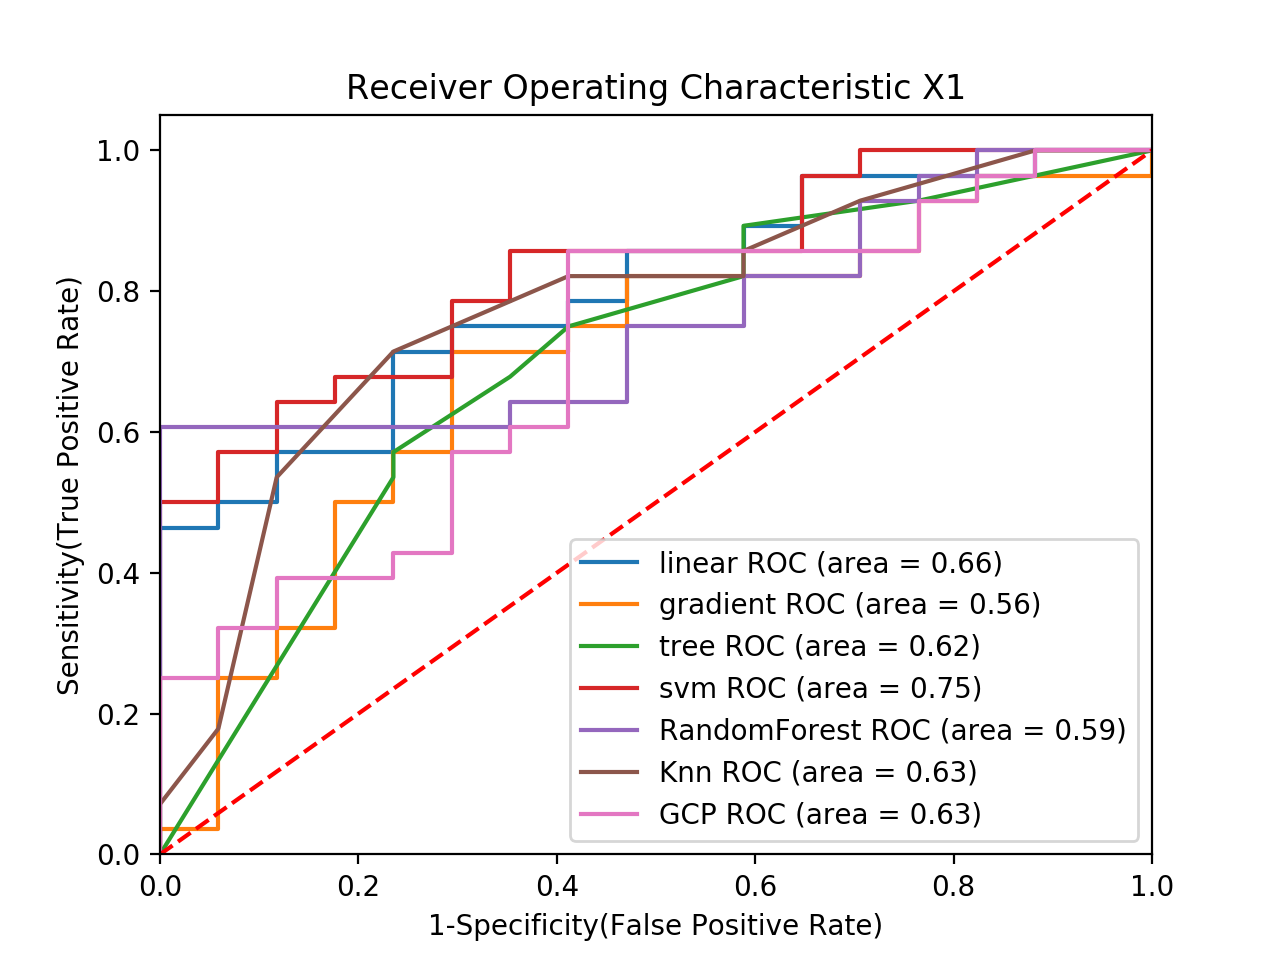

In [519]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X1:
    model =Bestmodels_X1[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X1_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X1_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X1')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X1.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [487]:
Bestmodels_X2, result_X2  = grid('X2', -1, X2_train, y_train.values, X2_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/pyt

Saving model at modelos/X2linear_20190926-2105.sav
El tiempo de seleccion fue: 0.296 s
El error roc_auc de la familia linear es: 0.758
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s


Saving model at modelos/X2gradient_20190926-2105.sav
El tiempo de seleccion fue: 0.700 s
El error roc_auc de la familia gradient es: 0.593
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X2tree_20190926-2105.sav
El tiempo de seleccion fue: 0.156 s
El error roc_auc de la familia tree es: 0.711
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A colu

Saving model at modelos/X2svm_20190926-2105.sav
El tiempo de seleccion fue: 0.040 s
El error roc_auc de la familia svm es: 0.730
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Saving model at modelos/X2RandomForest_20190926-2105.sav
El tiempo de seleccion fue: 1.152 s
El error roc_auc de la familia RandomForest es: 0.713
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X2Knn_20190926-2105.sav
El tiempo de seleccion fue: 0.142 s
El error roc_auc de la familia Knn es: 0.728
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X2GCP_20190926-2105.sav
El tiempo de seleccion fue: 0.048 s
El error roc_auc de la familia GCP es: 0.661
********************************************************************************
best model: linear with an error roc_auc of: 0.75

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_

In [520]:
coef_beta = Bestmodels_X2['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X2 = Bestmodels_X2['linear']['cols_order'].tolist()

In [521]:
coef_beta[0][0]

0.2624699241881524

In [522]:
for i in range(len(var_X2)):
    print(var_X2[i] +': '+ str(coef_beta[0][i]))

x1: 0.2624699241881524
x2: -0.10271326933547206
x4: -0.41960493579231095
x10: 0.20590804837592716
x11: 0.0
x12: -0.3422197917302315
x17: -0.5951945065511565
x21: 0.24387700868397016
x23: 0.8380192148620774
x25: 0.0
x27: 0.0


<IPython.core.display.Javascript object>


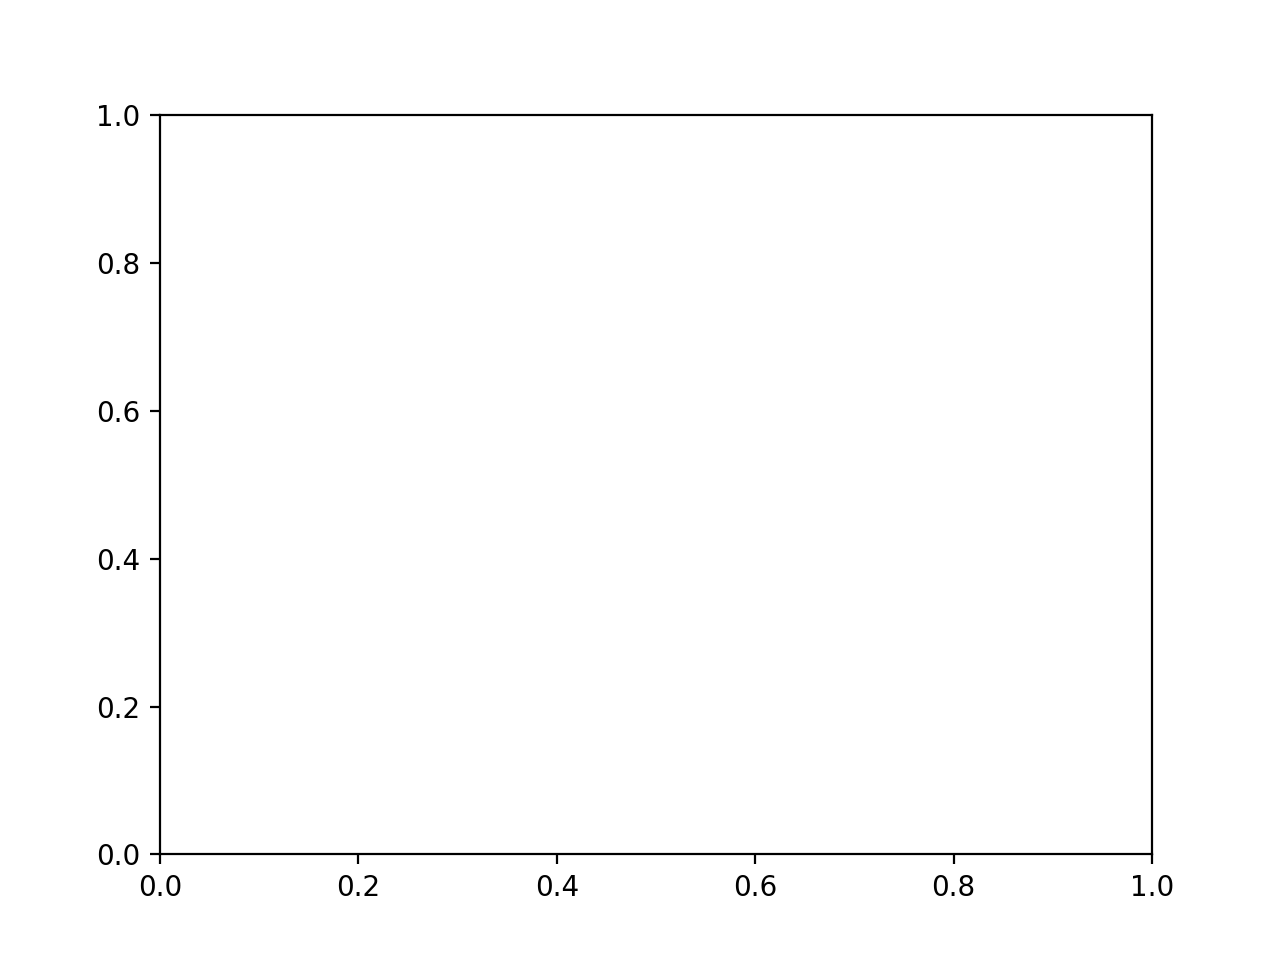

ValueError: operands could not be broadcast together with shapes (45,12) (11,) (45,12) 

In [523]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X2:
    model =Bestmodels_X2[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X2_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X2_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X2')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X2.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [492]:
Bestmodels_X3, result_X3  = grid('X3', -1, X3_train, y_train.values, X3_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)

Saving model at modelos/X3linear_20190926-2106.sav
El tiempo de seleccion fue: 0.307 s
El error roc_auc de la familia linear es: 0.752
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_s

Saving model at modelos/X3gradient_20190926-2106.sav
El tiempo de seleccion fue: 0.513 s
El error roc_auc de la familia gradient es: 0.598
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X3tree_20190926-2106.sav
El tiempo de seleccion fue: 0.140 s
El error roc_auc de la familia tree es: 0.694
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X3svm_20190926-2106.sav
El tiempo de seleccion fue: 0.030 s
El error roc_auc de la familia svm es: 0.714
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:81

Saving model at modelos/X3RandomForest_20190926-2106.sav
El tiempo de seleccion fue: 1.017 s
El error roc_auc de la familia RandomForest es: 0.701
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X3Knn_20190926-2106.sav
El tiempo de seleccion fue: 0.106 s
El error roc_auc de la familia Knn es: 0.721
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X3GCP_20190926-2106.sav
El tiempo de seleccion fue: 0.049 s
El error roc_auc de la familia GCP es: 0.655
********************************************************************************
best model: linear with an error roc_auc of: 0.75

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parame

<IPython.core.display.Javascript object>


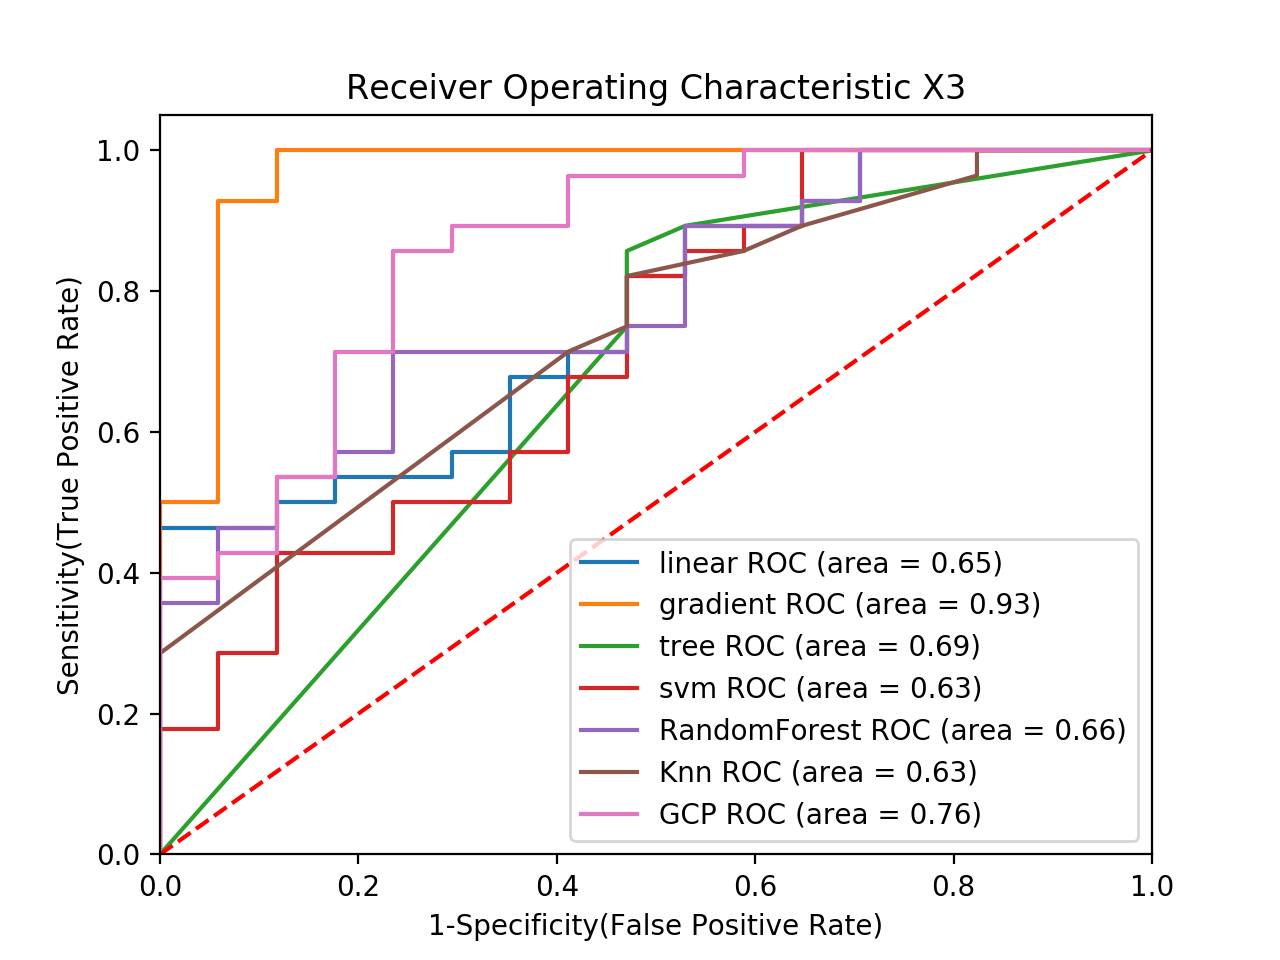

In [524]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X3:
    model =Bestmodels_X3[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X3_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X3_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X3')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X3.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [442]:
Bestmodels_X4, result_X4  = grid('X4', -1, X4_train, y_train.values, X4_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)

Saving model at modelos/X4linear_20190926-2057.sav
El tiempo de seleccion fue: 0.328 s
El error roc_auc de la familia linear es: 0.730
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s


Saving model at modelos/X4gradient_20190926-2057.sav
El tiempo de seleccion fue: 0.723 s
El error roc_auc de la familia gradient es: 0.629
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/pytho

Saving model at modelos/X4tree_20190926-2057.sav
El tiempo de seleccion fue: 0.225 s
El error roc_auc de la familia tree es: 0.687
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X4svm_20190926-2057.sav
El tiempo de seleccion fue: 0.042 s
El error roc_auc de la familia svm es: 0.675
********************************************************************************
********************************************************************************
Model: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Saving model at modelos/X4RandomForest_20190926-2057.sav
El tiempo de seleccion fue: 0.968 s
El error roc_auc de la familia RandomForest es: 0.674
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X4Knn_20190926-2057.sav
El tiempo de seleccion fue: 0.118 s
El error roc_auc de la familia Knn es: 0.732
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X4GCP_20190926-2057.sav
El tiempo de seleccion fue: 0.044 s
El error roc_auc de la familia GCP es: 0.660
********************************************************************************
best model: Knn with an error roc_auc of: 0.73233

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  37 out of  45 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/mo

<IPython.core.display.Javascript object>


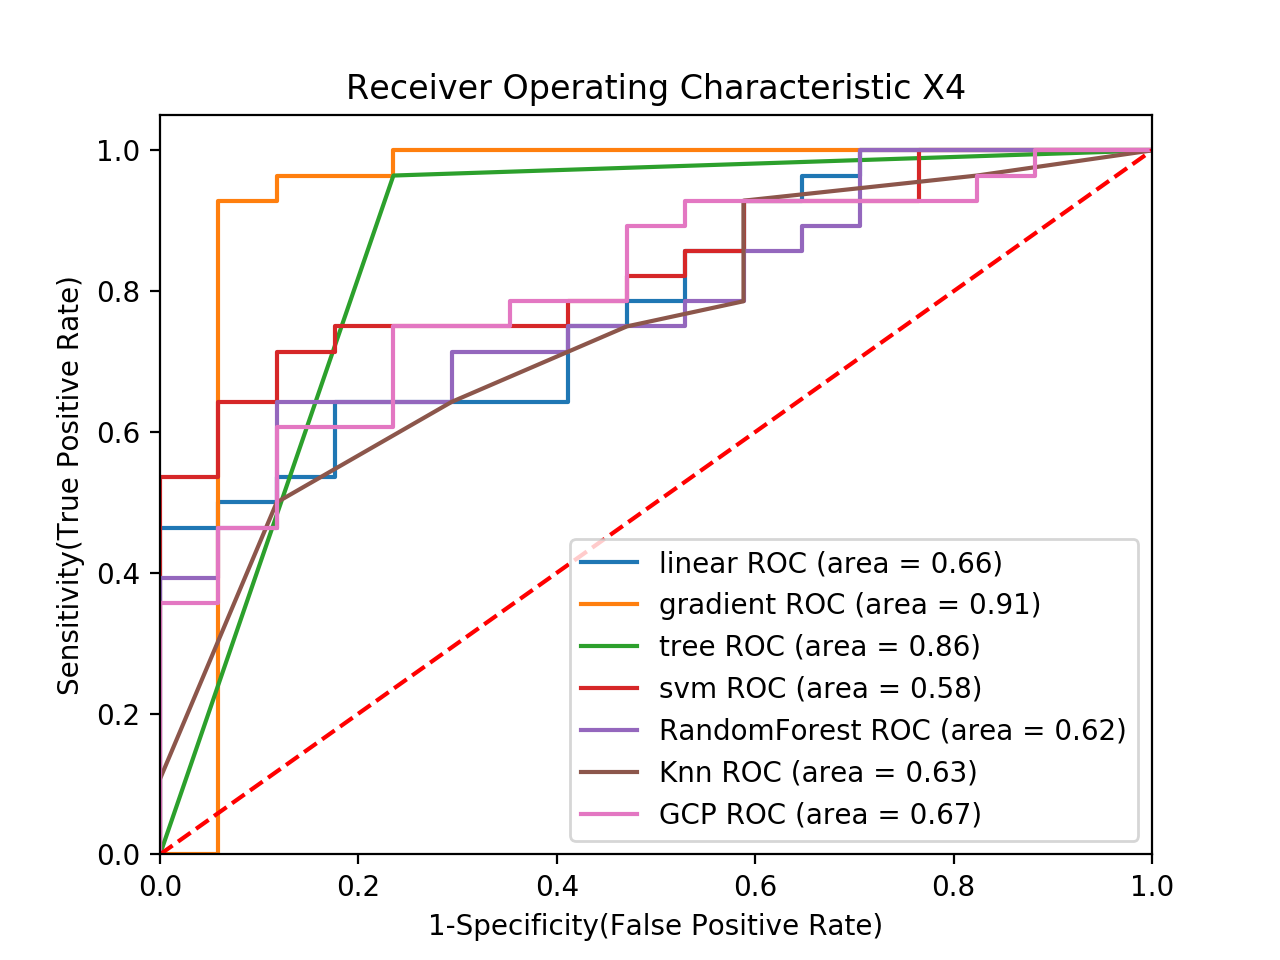

In [525]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X4:
    model =Bestmodels_X4[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X4_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X4_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X4')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X4.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [413]:
Bestmodels_X5, result_X5  = grid('X5', -1, X5_train, y_train.values, X5_test, y_test, models, score = 'roc_auc', cv = 5)

********************************************************************************
Model: linear
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1

Saving model at modelos/X5linear_20190926-2054.sav
El tiempo de seleccion fue: 0.328 s
El error roc_auc de la familia linear es: 0.768
********************************************************************************
********************************************************************************
Model: gradient
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.6s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 out of 120 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   

Saving model at modelos/X5gradient_20190926-2054.sav
El tiempo de seleccion fue: 0.637 s
El error roc_auc de la familia gradient es: 0.709
********************************************************************************
********************************************************************************
Model: tree
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Saving model at modelos/X5tree_20190926-2054.sav
El tiempo de seleccion fue: 0.138 s
El error roc_auc de la familia tree es: 0.740
********************************************************************************
********************************************************************************
Model: svm
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Saving model at modelos/X5svm_20190926-2054.sav
El tiempo de seleccion fue: 0.030 s
El error roc_auc de la familia svm es: 0.781
********************************************************************************
***************************************************

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.9s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Saving model at modelos/X5RandomForest_20190926-2054.sav
El tiempo de seleccion fue: 1.006 s
El error roc_auc de la familia RandomForest es: 0.776
********************************************************************************
********************************************************************************
Model: Knn
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Saving model at modelos/X5Knn_20190926-2054.sav
El tiempo de seleccion fue: 0.115 s
El error roc_auc de la familia Knn es: 0.736
********************************************************************************
********************************************************************************
Model: GCP
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Saving model at modelos/X5GCP_20190926-2054.sav
El tiempo de seleccion fue: 0.050 s
El error roc_auc de la familia GCP es: 0.709
********************************************************************************
best model: svm with an error roc_auc of: 0.78117

[Parallel(n_jobs=-1)]: Done  14 out of  45 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.1s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parame

<IPython.core.display.Javascript object>


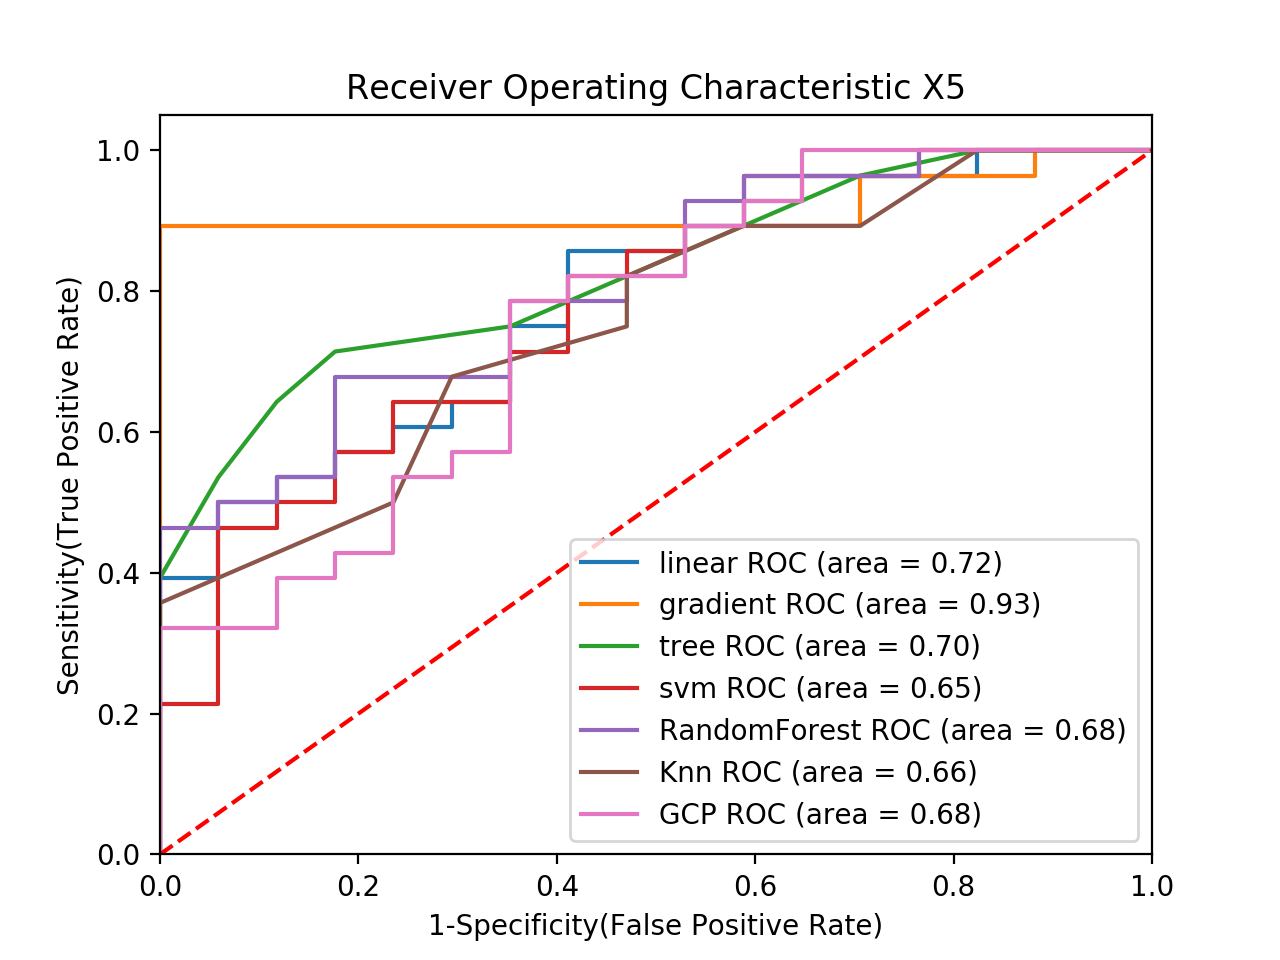

In [526]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [242]:
coef_beta = Bestmodels_X5['linear']['bestModel'].named_steps.linear.coef_.tolist()
var_X5 = Bestmodels_X5['linear']['cols_order'].tolist()
for i in range(len(var_X5)):
    print(var_X5[i] +': '+ str(coef_beta[0][i]))

x1: 0.697451913412629
x10: 0.14855249586391248
x12: -0.08079475800619886
x17: -0.3099700465487807
x23: 0.7760402458834124


<IPython.core.display.Javascript object>


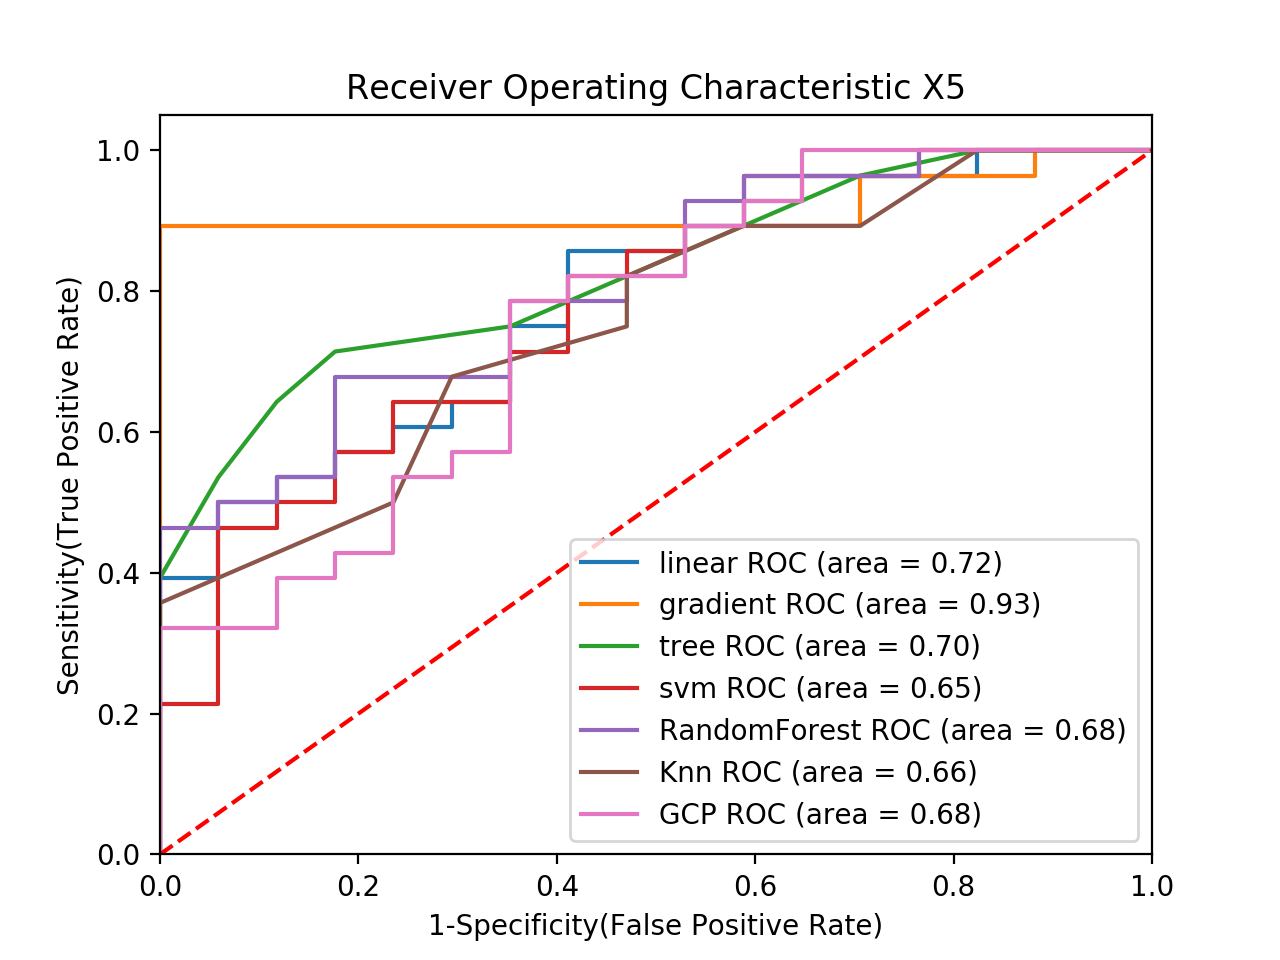

In [527]:
%matplotlib notebook
fig, ax = plt.subplots()
for m in Bestmodels_X5:
    model =Bestmodels_X5[m]['bestModel'] # select the model
#     y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X5_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X5_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic X5')
plt.legend(loc="lower right")
plt.show()   # Display
plt.savefig('Bestmodels_X5.png', facecolor=fig.get_facecolor(), bbox_inches='tight')

In [529]:
result_X1

{'linear': {'auc': 0.658, 'accuracy': 0.689},
 'gradient': {'auc': 0.558, 'accuracy': 0.622},
 'tree': {'auc': 0.617, 'accuracy': 0.667},
 'svm': {'auc': 0.752, 'accuracy': 0.778},
 'RandomForest': {'auc': 0.587, 'accuracy': 0.644},
 'Knn': {'auc': 0.634, 'accuracy': 0.689},
 'GCP': {'auc': 0.634, 'accuracy': 0.689}}

In [530]:
result_X2

{'linear': {'auc': 0.66, 'accuracy': 0.711},
 'gradient': {'auc': 0.475, 'accuracy': 0.578},
 'tree': {'auc': 0.637, 'accuracy': 0.711},
 'svm': {'auc': 0.714, 'accuracy': 0.756},
 'RandomForest': {'auc': 0.599, 'accuracy': 0.689},
 'Knn': {'auc': 0.614, 'accuracy': 0.711},
 'GCP': {'auc': 0.606, 'accuracy': 0.667}}

In [531]:
result_X3

{'linear': {'auc': 0.675, 'accuracy': 0.733},
 'gradient': {'auc': 0.567, 'accuracy': 0.644},
 'tree': {'auc': 0.683, 'accuracy': 0.711},
 'svm': {'auc': 0.66, 'accuracy': 0.711},
 'RandomForest': {'auc': 0.599, 'accuracy': 0.689},
 'Knn': {'auc': 0.614, 'accuracy': 0.711},
 'GCP': {'auc': 0.599, 'accuracy': 0.689}}

In [532]:
result_X4

{'linear': {'auc': 0.726, 'accuracy': 0.756},
 'gradient': {'auc': 0.709, 'accuracy': 0.733},
 'tree': {'auc': 0.647, 'accuracy': 0.689},
 'svm': {'auc': 0.605, 'accuracy': 0.689},
 'RandomForest': {'auc': 0.73, 'accuracy': 0.778},
 'Knn': {'auc': 0.73, 'accuracy': 0.778},
 'GCP': {'auc': 0.681, 'accuracy': 0.733}}

In [533]:
result_X5

{'linear': {'auc': 0.652, 'accuracy': 0.8},
 'gradient': {'auc': 0.566, 'accuracy': 0.622},
 'tree': {'auc': 0.491, 'accuracy': 0.556},
 'svm': {'auc': 0.561, 'accuracy': 0.756},
 'RandomForest': {'auc': 0.638, 'accuracy': 0.778},
 'Knn': {'auc': 0.592, 'accuracy': 0.756},
 'GCP': {'auc': 0.638, 'accuracy': 0.778}}

In [534]:
# Forma en que vas a llamar la función
resultado = get_max(result_X1, 'auc')
best_X1 = {}
best_X1[resultado[0]] = resultado[1]
print('BestX1: ' + str(best_X1))


resultado = get_max(result_X2, 'auc')
best_X2 = {}
best_X2[resultado[0]] = resultado[1]
print('BestX2: ' + str(best_X2))

resultado = get_max(result_X3, 'auc')
best_X3 = {}
best_X3[resultado[0]] = resultado[1]
print('BestX3: ' + str(best_X3))


resultado = get_max(result_X4, 'auc')
best_X4 = {}
best_X4[resultado[0]] = resultado[1]
print('BestX4: ' + str(best_X4))


resultado = get_max(result_X5, 'auc')
best_X5 = {}
best_X5[resultado[0]] = resultado[1]
print('BestX5: ' + str(best_X5))

BestX1: {'svm': 0.752}
BestX2: {'svm': 0.714}
BestX3: {'tree': 0.683}
BestX4: {'Knn': 0.73}
BestX5: {'linear': 0.652}


In [535]:
# Mejor Modelo según accuracy
resultado = get_max(result_X1, 'accuracy')
best_X1 = {}
best_X1[resultado[0]] = resultado[1]
print('BestX1: ' + str(best_X1))


resultado = get_max(result_X2, 'accuracy')
best_X2 = {}
best_X2[resultado[0]] = resultado[1]
print('BestX2: ' + str(best_X2))

resultado = get_max(result_X3, 'accuracy')
best_X3 = {}
best_X3[resultado[0]] = resultado[1]
print('BestX3: ' + str(best_X3))


resultado = get_max(result_X4, 'accuracy')
best_X4 = {}
best_X4[resultado[0]] = resultado[1]
print('BestX4: ' + str(best_X4))


resultado = get_max(result_X5, 'accuracy')
best_X5 = {}
best_X5[resultado[0]] = resultado[1]
print('BestX5: ' + str(best_X5))

BestX1: {'svm': 0.778}
BestX2: {'svm': 0.756}
BestX3: {'linear': 0.733}
BestX4: {'Knn': 0.778}
BestX5: {'linear': 0.8}


In [538]:
Selected_model = Bestmodels_X5['tree']
Bestmodels_X5['tree']

{'mod': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'par': {'splitter': ('best', 'random'),
  'max_depth': [None, 2, 4, 6],
  'min_samples_leaf': [1, 5, 8]},
 'bestModel': Pipeline(memory=None,
          steps=[('scaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('tree',
                  DecisionTreeClassifier(class_weight=None, criterion='gini',
                                         max_depth=6, max_features=None,
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                          

In [539]:
import pickle 
pickle.dump(Selected_model, open('modelBinary.sav', 'wb'))